Enter two stock tickers for the pairs trading strategy.


2025-04-17 14:00:46,303 - INFO - Fetching data for ['DAL', 'KO']
2025-04-17 14:00:46,470 - INFO - Data fetched for DAL
2025-04-17 14:00:58,686 - INFO - Data fetched for KO
2025-04-17 14:01:10,706 - INFO - Testing cointegration...
2025-04-17 14:01:10,723 - INFO - Cointegration p-value: 5.9050087378007924e-05
2025-04-17 14:01:10,723 - INFO - Pair is cointegrated. Proceeding with strategy.
2025-04-17 14:01:10,723 - INFO - Starting backtest...
C:\Users\tvenu\AppData\Local\Temp\ipykernel_42720\1507788943.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi = (cumulative_returns[-1] / self.portfolio_value - 1) * 100
2025-04-17 14:01:10,743 - INFO - ROI: 24.62%
2025-04-17 14:01:10,743 - INFO - Sharpe Ratio: 1.33
2025-04-17 14:01:10,743 - INFO - Max Drawdown: 7.28%
2025-04-17 14:01:10,743 - INFO - Starti

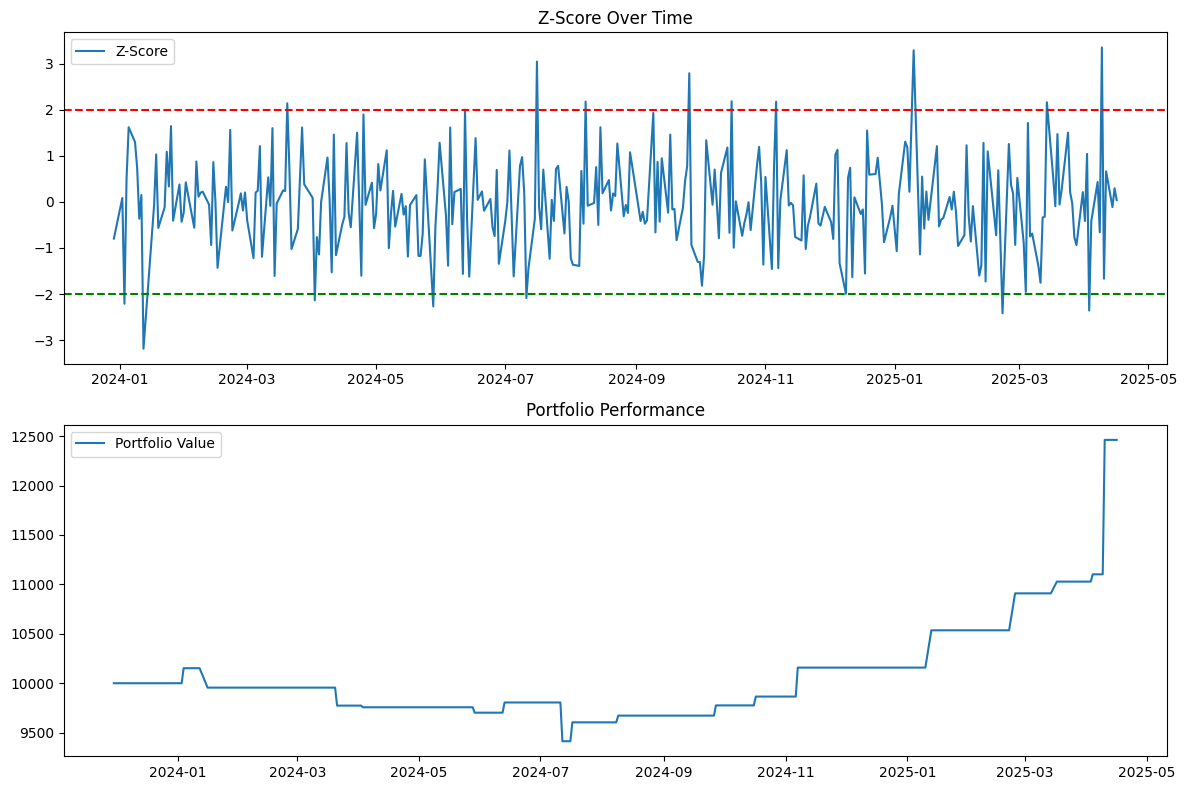

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import time
import logging
from datetime import datetime, timedelta
import threading
import queue

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

API_RATE_LIMIT = 5  
Z_SCORE_THRESHOLD_BUY = -2.0
Z_SCORE_THRESHOLD_SELL = 2.0
LOOKBACK_PERIOD = 20  

class PairsTradingBot:
    def __init__(self, pair_symbols, start_date, end_date):
        self.pair_symbols = pair_symbols  
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.log_returns = None  
        self.spread = None
        self.z_scores = None
        self.positions = pd.DataFrame()
        self.portfolio_value = 10000  
        self.trade_log = []
        self.request_queue = queue.Queue()
        self.lock = threading.Lock()

    def fetch_data(self):
        """Fetch historical data from Yahoo Finance with rate limiting."""
        logger.info(f"Fetching data for {self.pair_symbols}")
        for symbol in self.pair_symbols:
            self.request_queue.put(symbol)
        
        def process_queue():
            while not self.request_queue.empty():
                with self.lock:
                    symbol = self.request_queue.get()
                    ticker = yf.Ticker(symbol)
                    df = ticker.history(start=self.start_date, end=self.end_date)
                    if self.data is None:
                        self.data = pd.DataFrame(index=df.index)
                    self.data[symbol] = df['Close']
                    logger.info(f"Data fetched for {symbol}")
                    time.sleep(60 / API_RATE_LIMIT) 
        
        thread = threading.Thread(target=process_queue)
        thread.start()
        thread.join()
        
        if self.data is None or self.data.empty:
            raise ValueError("No data fetched. Check symbols or API connectivity.")
        self.data.dropna(inplace=True)
        
        self.log_returns = np.log(self.data / self.data.shift(1))
        self.log_returns.dropna(inplace=True)  

    def test_cointegration(self):
        """Perform Engle-Granger cointegration test on log returns."""
        logger.info("Testing cointegration...")
        stock1, stock2 = self.pair_symbols
        score, p_value, _ = coint(self.log_returns[stock1], self.log_returns[stock2])
        logger.info(f"Cointegration p-value: {p_value}")
        return p_value < 0.05  

    def calculate_spread_and_zscore(self):
        """Calculate spread and Z-scores using log returns.""" 
        stock1, stock2 = self.pair_symbols
        model = sm.OLS(self.log_returns[stock1], sm.add_constant(self.log_returns[stock2])).fit()
        hedge_ratio = model.params[stock2]
        

        self.spread = self.log_returns[stock1] - hedge_ratio * self.log_returns[stock2]

        spread_mean = self.spread.rolling(window=LOOKBACK_PERIOD).mean()
        spread_std = self.spread.rolling(window=LOOKBACK_PERIOD).std()
        self.z_scores = (self.spread - spread_mean) / spread_std
        self.z_scores.dropna(inplace=True)

    def generate_signals(self):
        """Generate trading signals based on Z-scores."""
        signals = pd.DataFrame(index=self.z_scores.index)
        signals['Z-Score'] = self.z_scores
        signals['Signal'] = 0
        
        signals.loc[signals['Z-Score'] < Z_SCORE_THRESHOLD_BUY, 'Signal'] = 1
        signals.loc[signals['Z-Score'] > Z_SCORE_THRESHOLD_SELL, 'Signal'] = -1
        
        return signals

    def backtest(self):
        """Backtest the strategy."""
        logger.info("Starting backtest...")
        signals = self.generate_signals()
        self.positions = pd.DataFrame(index=signals.index, columns=self.pair_symbols)
        
        for i in range(1, len(signals)):
            if signals['Signal'].iloc[i] == 1:  
                self.positions.iloc[i, 0] = 1  
                self.positions.iloc[i, 1] = -1  
            elif signals['Signal'].iloc[i] == -1:  
                self.positions.iloc[i, 0] = -1  
                self.positions.iloc[i, 1] = 1  
            else:
                self.positions.iloc[i] = [0, 0]  

        returns = self.positions.shift(1) * self.data.pct_change()
        portfolio_returns = returns.sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod() * self.portfolio_value

        roi = (cumulative_returns[-1] / self.portfolio_value - 1) * 100
        sharpe_ratio = np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std()
        drawdown = (cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()
        max_drawdown = drawdown.max() * 100
        
        logger.info(f"ROI: {roi:.2f}%")
        logger.info(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        logger.info(f"Max Drawdown: {max_drawdown:.2f}%")
        
        return cumulative_returns, roi, sharpe_ratio, max_drawdown

    def paper_trade(self):
        """Simulate paper trading in real-time (mocked here with historical data)."""
        logger.info("Starting paper trading simulation...")
        signals = self.generate_signals()
        cash = self.portfolio_value
        holdings = {symbol: 0 for symbol in self.pair_symbols}
        
        for date, row in signals.iterrows():
            stock1, stock2 = self.pair_symbols
            price1, price2 = self.data[stock1].loc[date], self.data[stock2].loc[date]
            
            if row['Signal'] == 1:  
                if cash >= price1:
                    holdings[stock1] += 1
                    holdings[stock2] -= 1
                    cash -= price1
                    cash += price2
                    self.trade_log.append(f"{date}: Buy {stock1}, Sell {stock2}")
            elif row['Signal'] == -1: 
                if cash >= price2:
                    holdings[stock1] -= 1
                    holdings[stock2] += 1
                    cash += price1
                    cash -= price2
                    self.trade_log.append(f"{date}: Sell {stock1}, Buy {stock2}")
            
            portfolio_value = cash + holdings[stock1] * price1 + holdings[stock2] * price2
            logger.info(f"{date}: Portfolio Value: {portfolio_value:.2f}")
        
        logger.info("Paper trading completed.")
        logger.info(f"Final Portfolio Value: {portfolio_value:.2f}")
        for log in self.trade_log[-5:]:
            logger.info(log)

    def plot_results(self, cumulative_returns):
        """Plot Z-scores and portfolio performance."""
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(self.z_scores, label='Z-Score')
        plt.axhline(Z_SCORE_THRESHOLD_BUY, color='g', linestyle='--')
        plt.axhline(Z_SCORE_THRESHOLD_SELL, color='r', linestyle='--')
        plt.legend()
        plt.title('Z-Score Over Time')
        
        plt.subplot(2, 1, 2)
        plt.plot(cumulative_returns, label='Portfolio Value')
        plt.legend()
        plt.title('Portfolio Performance')
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":

    print("Enter two stock tickers for the pairs trading strategy.")
    ticker1 = input("Enter first ticker (e.g., AAPL): ").strip().upper()
    ticker2 = input("Enter second ticker (e.g., MSFT): ").strip().upper()

    if ticker1 == ticker2:
        raise ValueError("The two tickers must be different.")

    pair_symbols = [ticker1, ticker2]


    end_date = datetime.now()
    start_date = end_date - timedelta(days=504)  

    bot = PairsTradingBot(pair_symbols, start_date, end_date)
    bot.fetch_data()
    if bot.test_cointegration():
        logger.info("Pair is cointegrated. Proceeding with strategy.")
        bot.calculate_spread_and_zscore()
        cumulative_returns, roi, sharpe, drawdown = bot.backtest()
        bot.paper_trade()
        bot.plot_results(cumulative_returns)
    else:
        logger.warning("Pair is not cointegrated. Strategy aborted.")

